## Tecnologias Utilizadas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import auc as sklearn_auc
from sklearn.model_selection import cross_val_score

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

Depois de analisar e tratar todos os dados, vamos passar para as etapas de modelação e avaliação. Assim, é necessário voltar a ler os dados do **dataset** tratado.

In [2]:
training_inputs = pd.read_csv('CreditCardTransactions/training_dataset.csv')
training_classes = pd.read_csv('CreditCardTransactions/training_classes.csv')
testing_inputs = pd.read_csv('CreditCardTransactions/testing_dataset.csv')
testing_classes = pd.read_csv('CreditCardTransactions/testing_classes.csv')

training_classes['is_fraud'] = training_classes['is_fraud'].astype('category')
testing_classes['is_fraud'] = testing_classes['is_fraud'].astype('category')

## Modelação e Avaliação

Ao longo do processo de modelação, foram implementados e avaliados diversos modelos de classificação para abordar o problema em questão, utilizando diferentes estratégias e técnicas de otimização. Abaixo, detalhamos cada uma das etapas realizadas.

Primeiramente, desenvolvemos um modelo de classificação baseado em **Árvores de Decisão**. Este modelo foi inicialmente treinado sem qualquer otimização de parâmetros, permitindo uma avaliação preliminar do seu desempenho. Em seguida, aplicamos **Grid Search** para encontrar os melhores parâmetros possíveis.

Adicionalmente, implementamos uma **Rede Neural**. Este modelo, pertencente ao domínio do **Deep Learning**, foi configurado com o objetivo de identificar padrões complexos nos dados e fornecer previsões mais robustas. No entanto, devido ao elevado custo computacional e à necessidade de grandes recursos para explorar diferentes combinações de parâmetros, o **Grid Search** não foi aplicado.

Outro modelo avaliado foi a **Support Vector Machine (SVM)**. Esta abordagem foca em encontrar o hiperplano que melhor separa as classes, maximizando a margem entre os dados de diferentes categorias. Tal como a **Rede Neural**, o **Grid Search** também foi omitido para o modelo **SVM**, devido ao tempo computacional elevado necessário.

Em seguida, treinamos um **Random Forest Classifier**, que, sendo um modelo de **ensembling**, combina várias **Árvores de Decisão** para melhorar a robustez e a precisão. Este modelo foi otimizado utilizando **Grid Search**, o que permitiu identificar os melhores parâmetros.

Além disso, implementamos uma **Regressão Logística**, que é amplamente utilizada em problemas de **classificação binária** devido à sua simplicidade. Este modelo foi também otimizado com **Grid Search**, explorando diferentes valores para parâmetros.

Para avaliar todos os modelos, foram utilizadas diversas **métricas**, como **AUC (Area Under the Curve)**, **F1 Score**, **Precisão** e **Recall**, de modo a garantir uma visão abrangente do desempenho de cada abordagem. Além disso, para cada modelo, foram geradas **Matrizes de Confusão** para interpretar os resultados e identificar possíveis desequilíbrios na classificação. Também foi traçada a **Curva ROC** de cada modelo, permitindo a análise visual da relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos.

Utilizamos o método **SMOTE** combinado com **Tomek Links**, uma técnica que integra **oversampling** das classes minoritárias e **undersampling informado** das classes majoritárias. Essa estratégia foi aplicada para lidar com o **desbalanceamento** da variável-alvo, garantindo que os modelos tivessem dados mais equilibrados.

Além disso, todos os modelos foram testados com **validação cruzada (cross-validation)**, utilizando uma **Pipeline** para integrar o **SMOTE-Tomek Links**.

Metrics (Árvore de Decisão S/ GridSearch):
AUC Score: 49.20%
Precision: 0.90%
Recall: 1.40%
F1-Measure: 1.10%


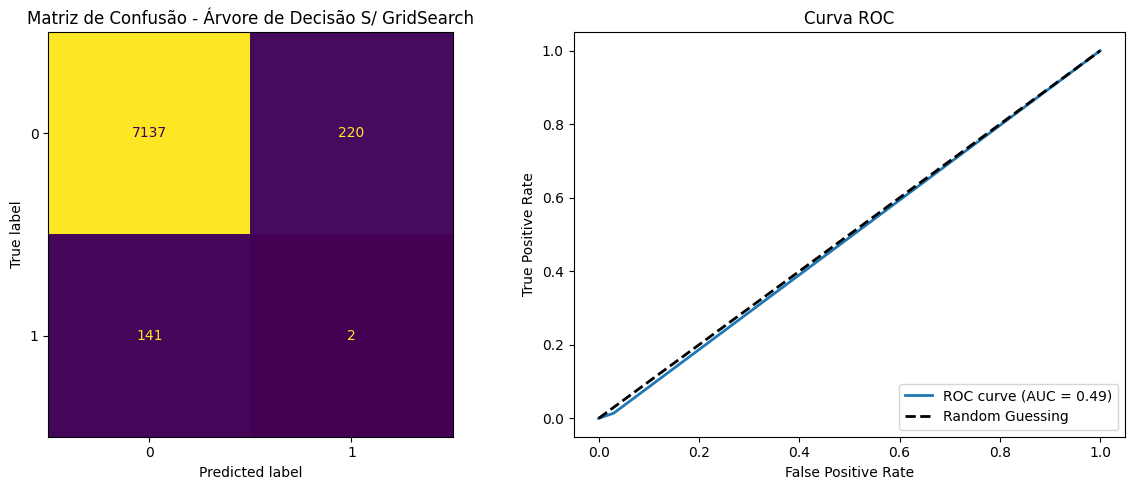

In [ ]:
pipeline = Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42, sampling_strategy=0.4)),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

sf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = cross_val_score(pipeline, training_inputs, training_classes, cv=sf, scoring='roc_auc')
pipeline.fit(training_inputs, training_classes)

# Fazer previsões no conjunto de teste
predictions = pipeline.predict(testing_inputs)

# Calcular as probabilidades previstas para calcular o AUC
probas = pipeline.predict_proba(testing_inputs)[:, 1]

# Calcular as métricas
DTSG_precision = precision_score(testing_classes, predictions)
DTSG_recall = recall_score(testing_classes, predictions)
DTSG_f1 = f1_score(testing_classes, predictions)

# Calcular o AUC
fpr, tpr, _ = roc_curve(testing_classes, probas)
DTSG_auc = sklearn_auc(fpr, tpr)

print("Metrics (Árvore de Decisão S/ GridSearch):")
print(f"AUC Score: {DTSG_auc * 100:.2f}%")
print(f"Precision: {DTSG_precision * 100:.2f}%")
print(f"Recall: {DTSG_recall * 100:.2f}%")
print(f"F1-Measure: {DTSG_f1 * 100:.2f}%")

# Matriz de Confusão
confusion_matrix_result = confusion_matrix(testing_classes, predictions)
confusion_display = ConfusionMatrixDisplay(confusion_matrix_result)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão
confusion_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusão - Árvore de Decisão S/ GridSearch")

# Curva ROC
axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {DTSG_auc:.2f})", lw=2)
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [4]:
decision_tree = DecisionTreeClassifier(random_state=42)

decision_tree_parameter_grid = {
    'model__min_samples_split': [2, 3, 4],
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_leaf': [1, 2]
}

# Pipeline com SMOTE dentro do CV
pipeline = Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42, sampling_strategy=0.4)),
    ('model', decision_tree)
])

sf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# GridSearchCV com o Pipeline
decision_tree_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=decision_tree_parameter_grid,
    scoring='roc_auc',
    cv=sf,
    n_jobs=-1
)

decision_tree_grid_search.fit(training_inputs, training_classes)

print('Decision Tree Best Score (roc): {:.2f}%'.format(decision_tree_grid_search.best_score_ * 100))
print('Decision Tree Best Parameters:', decision_tree_grid_search.best_params_)


Decision Tree Best Score (roc): 50.57%
Decision Tree Best Parameters: {'model__criterion': 'entropy', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}


In [5]:
best_decision_tree_params = decision_tree_grid_search.best_params_
best_decision_tree = DecisionTreeClassifier(
    min_samples_split=best_decision_tree_params['model__min_samples_split'],
    criterion=best_decision_tree_params['model__criterion'],
    min_samples_leaf=best_decision_tree_params['model__min_samples_leaf'],
    random_state=42
)
best_decision_tree.fit(training_inputs, training_classes) 

# Obter as probabilidades previstas no conjunto de teste
probas = best_decision_tree.predict_proba(testing_inputs)[:, 1]  
auc_score = roc_auc_score(testing_classes, probas)

# Prever as classes no conjunto de teste
predictions = best_decision_tree.predict(testing_inputs)

# Calcular as métricas
DTCG_precision = precision_score(testing_classes, predictions)
DTCG_recall = recall_score(testing_classes, predictions)
DTCG_f1 = f1_score(testing_classes, predictions)

print("Metrics (Árvore de Decisão C/ GridSearchCV):")
print("AUC Score: {:.2f}%".format(auc_score * 100))
print("Precision: {:.2f}%".format(DTCG_precision * 100))
print("Recall: {:.2f}%".format(DTCG_recall * 100))
print("F1-Measure: {:.2f}%".format(DTCG_f1 * 100))

Metrics (Árvore de Decisão C/ GridSearchCV):
AUC Score: 49.09%
Precision: 0.78%
Recall: 0.70%
F1-Measure: 0.74%


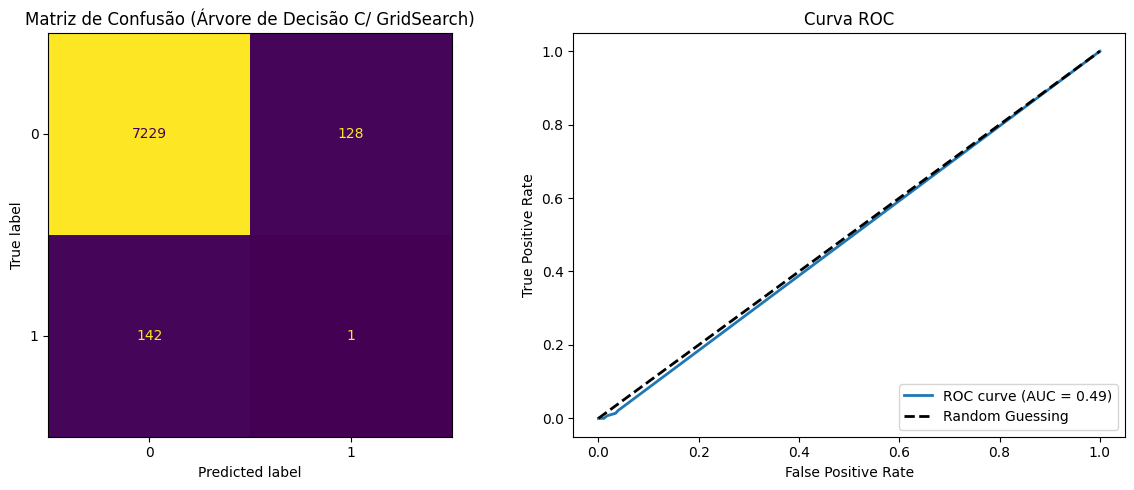

In [ ]:
confusion_matrix_result = confusion_matrix(testing_classes, predictions)
confusion_display = ConfusionMatrixDisplay(confusion_matrix_result)

# Curva ROC
fpr, tpr, _ = roc_curve(testing_classes, probas)
DTCG_auc = sklearn_auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão
confusion_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusão (Árvore de Decisão C/ GridSearch)")

# Curva ROC
axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {DTCG_auc:.2f})", lw=2)
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

Metrics (Rede Neural S/ GridSearch):
AUC Score: 55.32%
Precision: 1.30%
Recall: 0.70%
F1-Measure: 0.91%


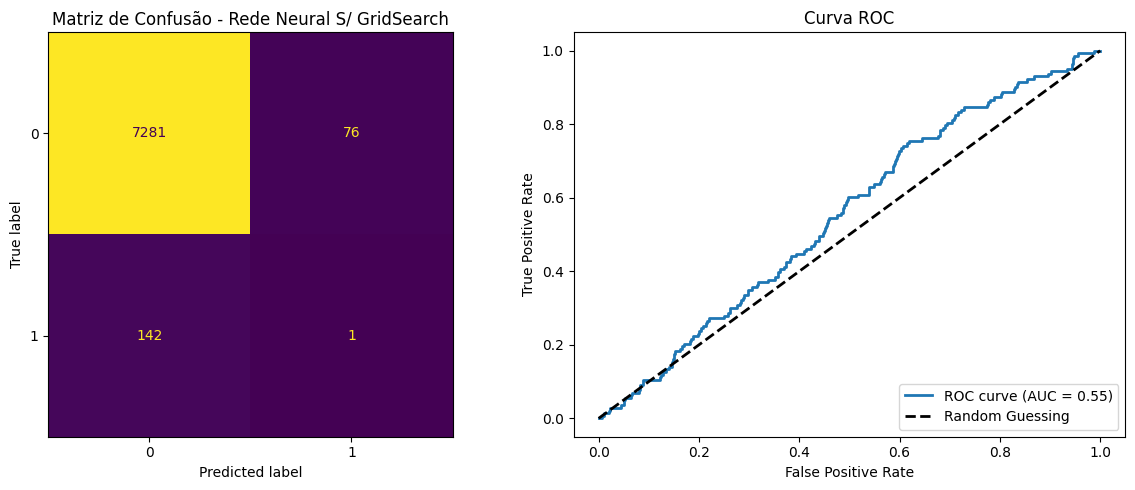

In [ ]:
pipeline = Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42, sampling_strategy=0.4)),
    ('neural_network', MLPClassifier(max_iter=1000, random_state=42))
])

sf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = cross_val_score(pipeline, training_inputs, training_classes, cv=sf, scoring='roc_auc')
pipeline.fit(training_inputs, training_classes)

predictions = pipeline.predict(testing_inputs)
probas = pipeline.predict_proba(testing_inputs)[:, 1]

# Calcular as métricas
NN_precision = precision_score(testing_classes, predictions)
NN_recall = recall_score(testing_classes, predictions)
NN_f1 = f1_score(testing_classes, predictions)
fpr, tpr, _ = roc_curve(testing_classes, probas)
NN_auc = sklearn_auc(fpr, tpr)

print("Metrics (Rede Neural S/ GridSearch):")
print(f"AUC Score: {NN_auc * 100:.2f}%")
print(f"Precision: {NN_precision * 100:.2f}%")
print(f"Recall: {NN_recall * 100:.2f}%")
print(f"F1-Measure: {NN_f1 * 100:.2f}%")

# Matriz de Confusão
confusion_matrix_result = confusion_matrix(testing_classes, predictions)
confusion_display = ConfusionMatrixDisplay(confusion_matrix_result)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão
confusion_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusão - Rede Neural S/ GridSearch")

# Curva ROC
axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {NN_auc:.2f})", lw=2)
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

Metrics (SVM S/ GridSearch):
AUC Score: 54.97%
Precision: 0.00%
Recall: 0.00%
F1-Measure: 0.00%


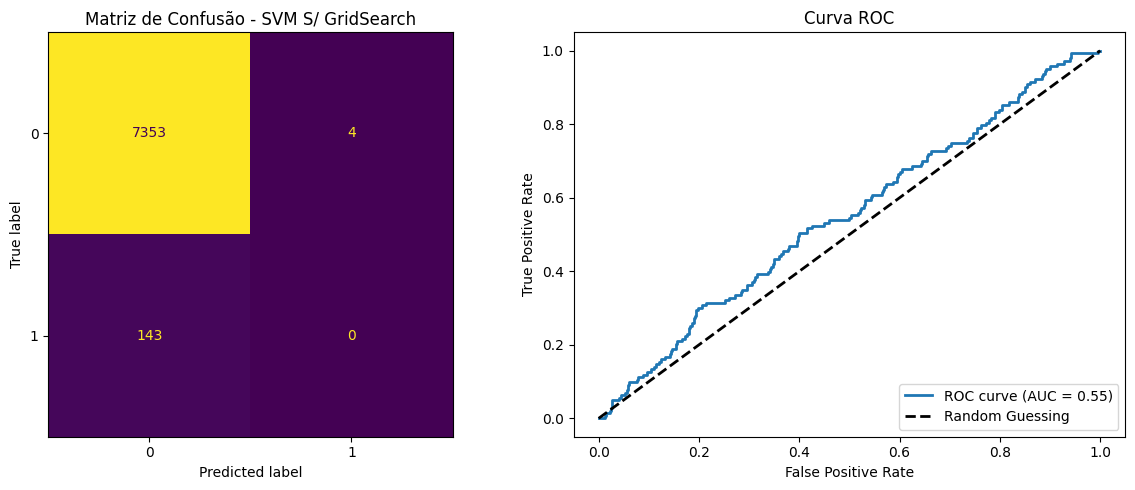

In [ ]:
pipeline = Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42, sampling_strategy=0.4)),
    ('svm', SVC(probability=True, random_state=42))
])

sf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = cross_val_score(pipeline, training_inputs, training_classes, cv=sf, scoring='roc_auc')
pipeline.fit(training_inputs, training_classes)

predictions = pipeline.predict(testing_inputs)

# Calcular as probabilidades previstas para calcular o AUC
probas = pipeline.predict_proba(testing_inputs)[:, 1]

# Calcular as métricas
SVM_precision = precision_score(testing_classes, predictions)
SVM_recall = recall_score(testing_classes, predictions)
SVM_f1 = f1_score(testing_classes, predictions)

# Calcular o AUC
fpr, tpr, _ = roc_curve(testing_classes, probas)
SVM_auc = sklearn_auc(fpr, tpr)

print("Metrics (SVM S/ GridSearch):")
print(f"AUC Score: {SVM_auc * 100:.2f}%")
print(f"Precision: {SVM_precision * 100:.2f}%")
print(f"Recall: {SVM_recall * 100:.2f}%")
print(f"F1-Measure: {SVM_f1 * 100:.2f}%")

# Matriz de Confusão
confusion_matrix_result = confusion_matrix(testing_classes, predictions)
confusion_display = ConfusionMatrixDisplay(confusion_matrix_result)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão
confusion_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusão - SVM S/ GridSearch")

# Curva ROC
axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {SVM_auc:.2f})", lw=2)
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [9]:
random_forest = RandomForestClassifier(random_state=42)

random_forest_parameter_grid = {    
    'model__max_features': ['log2', 'sqrt'],  
    'model__criterion': ['gini', 'entropy']
}

# Pipeline com SMOTE dentro do CV
pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42, sampling_strategy=0.4)),
    ('model', random_forest)
])

sf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# GridSearchCV com o Pipeline
random_forest_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=random_forest_parameter_grid,
    scoring='roc_auc',
    cv=sf,
    n_jobs=-1
)

random_forest_grid_search.fit(training_inputs, training_classes)

print('Random Forest Best Score (roc): {:.2f}%'.format(random_forest_grid_search.best_score_ * 100))
print('Random Forest Best Parameters:', random_forest_grid_search.best_params_)

Random Forest Best Score (roc): 52.19%
Random Forest Best Parameters: {'model__criterion': 'entropy', 'model__max_features': 'log2'}


In [ ]:
best_rf_params = random_forest_grid_search.best_params_
best_random_forest = RandomForestClassifier(
    max_features=best_rf_params['model__max_features'],
    criterion=best_rf_params['model__criterion'],
    random_state=42
)
best_random_forest.fit(training_inputs, training_classes)

# Obter as probabilidades previstas no conjunto de teste
probas = best_random_forest.predict_proba(testing_inputs)[:, 1]
auc_score = roc_auc_score(testing_classes, probas)

predictions = best_random_forest.predict(testing_inputs)

# Calcular as métricas
RF_precision = precision_score(testing_classes, predictions)
RF_recall = recall_score(testing_classes, predictions)
RF_f1 = f1_score(testing_classes, predictions)

print("Metrics (Random Forest C/ GridSearch):")
print(f"AUC Score: {auc_score * 100:.2f}%")
print(f"Precision: {SVM_precision * 100:.2f}%")
print(f"Recall: {SVM_recall * 100:.2f}%")
print(f"F1-Measure: {SVM_f1 * 100:.2f}%")

Metrics (Random Forest C/ GridSearch):
AUC Score: 54.28%
Precision: 0.00%
Recall: 0.00%
F1-Measure: 0.00%


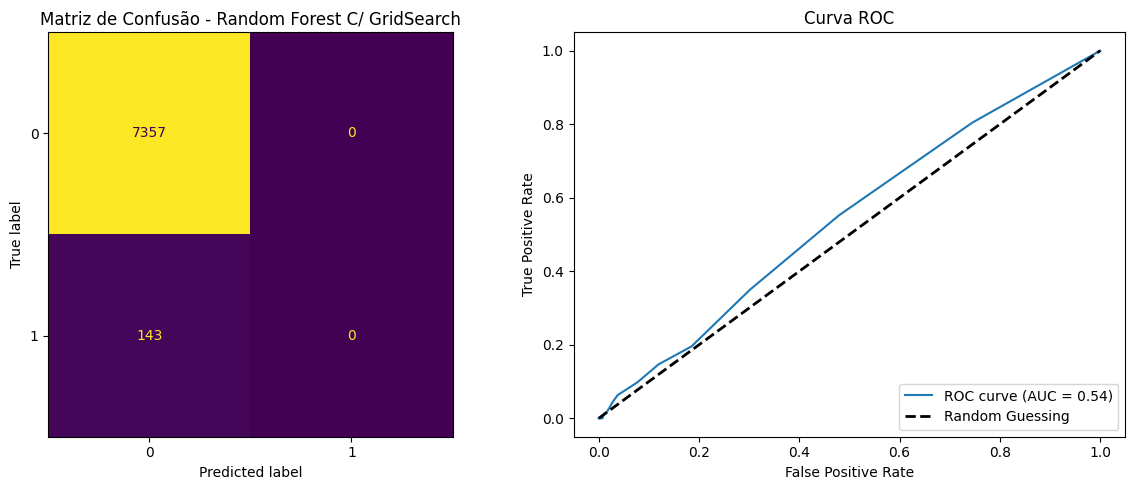

In [ ]:
confusion_matrix_result = confusion_matrix(testing_classes, predictions)
confusion_display = ConfusionMatrixDisplay(confusion_matrix_result)

# Curva ROC
fpr, tpr, thresholds = roc_curve(testing_classes, probas)
RF_auc = sklearn_auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusão
confusion_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusão - Random Forest C/ GridSearch")

# Curva ROC
axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {RF_auc:.2f})")
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [12]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)

logistic_regression_parameter_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.1, 1.0],
    'model__solver': ['liblinear', 'saga']
}

# Pipeline com SMOTE dentro do CV
pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42, sampling_strategy=0.4)),
    ('model', logistic_regression)
])

sf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# GridSearchCV com o Pipeline
logistic_regression_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=logistic_regression_parameter_grid,
    scoring='roc_auc',
    cv=sf,
    n_jobs=-1
)

logistic_regression_grid_search.fit(training_inputs, training_classes)

print('Logistic Regression Best Score (roc): {:.2f}%'.format(logistic_regression_grid_search.best_score_ * 100))
print('Logistic Regression Best Parameters:', logistic_regression_grid_search.best_params_)

Logistic Regression Best Score (roc): 53.35%
Logistic Regression Best Parameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [ ]:
best_lr_params = logistic_regression_grid_search.best_params_

best_logistic_regression = LogisticRegression(
    penalty=best_lr_params['model__penalty'],
    C=best_lr_params['model__C'],
    solver=best_lr_params['model__solver'],
    random_state=42,
    max_iter=1000
)
best_logistic_regression.fit(training_inputs, training_classes)

# Obter as probabilidades previstas no conjunto de teste
probas = best_logistic_regression.predict_proba(testing_inputs)[:, 1]
auc_score = roc_auc_score(testing_classes, probas)

predictions = best_logistic_regression.predict(testing_inputs)

# Calcular as métricas
LR_precision = precision_score(testing_classes, predictions)
LR_recall = recall_score(testing_classes, predictions)
LR_f1 = f1_score(testing_classes, predictions)

print("Metrics (Logistic Regression C/ GridSearch):")
print(f"AUC Score: {auc_score * 100:.2f}%")
print(f"Precision: {LR_precision * 100:.2f}%")
print(f"Recall: {LR_recall * 100:.2f}%")
print(f"F1-Measure: {LR_f1 * 100:.2f}%")

Metrics (Logistic Regression C/ GridSearch):
AUC Score: 50.26%
Precision: 0.00%
Recall: 0.00%
F1-Measure: 0.00%


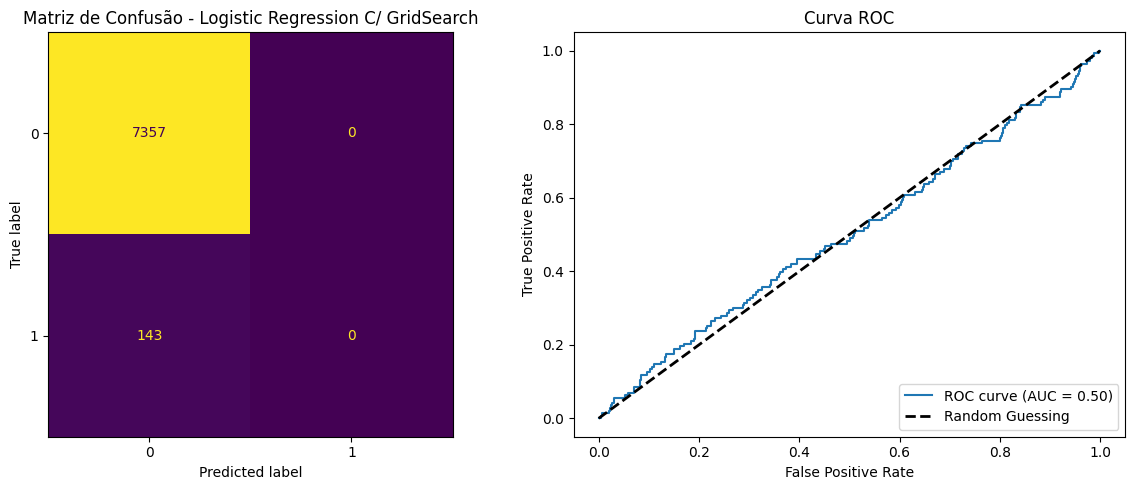

In [ ]:
# Matriz de confusão
confusion_matrix_result = confusion_matrix(testing_classes, predictions)
confusion_display = ConfusionMatrixDisplay(confusion_matrix_result)

# Curva ROC
fpr, tpr, thresholds = roc_curve(testing_classes, probas)
LR_auc = sklearn_auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusão
confusion_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusão - Logistic Regression C/ GridSearch")

# Curva ROC
axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {LR_auc:.2f})")
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


Depois de testados todos os modelos, foi criada uma **Tabela Comparativa** para resumir os resultados obtidos e identificar o modelo com melhor desempenho. Com base nessa tabela, selecionamos o modelo mais promissor e realizamos uma **Avaliação Final**.

| Modelo                          | Precision | Recall | F1-Score | AUC    |
|---------------------------------|-----------|--------|----------|--------|
| Decision Tree (sem GridSearch)  | 0.90%     | 1.40%  | 1.10%    | 49.20% |
| Decision Tree (com GridSearch)  | 0.78%     | 0.70%  | 0.74%    | 49.09% |
| Neural Network                  | 1.30%     | 0.70%  | 0.91%    | 55.32% |
| SVM                             | 0.00%     | 0.00%  | 0.00%    | 54.97% |
| Random Forest (com GridSearch)  | 0.00%     | 0.00%  | 0.00%    | 54.28% |
| Logistic Regression (com GridSearch) | 0.00%  | 0.00%  | 0.00%    | 50.26% |

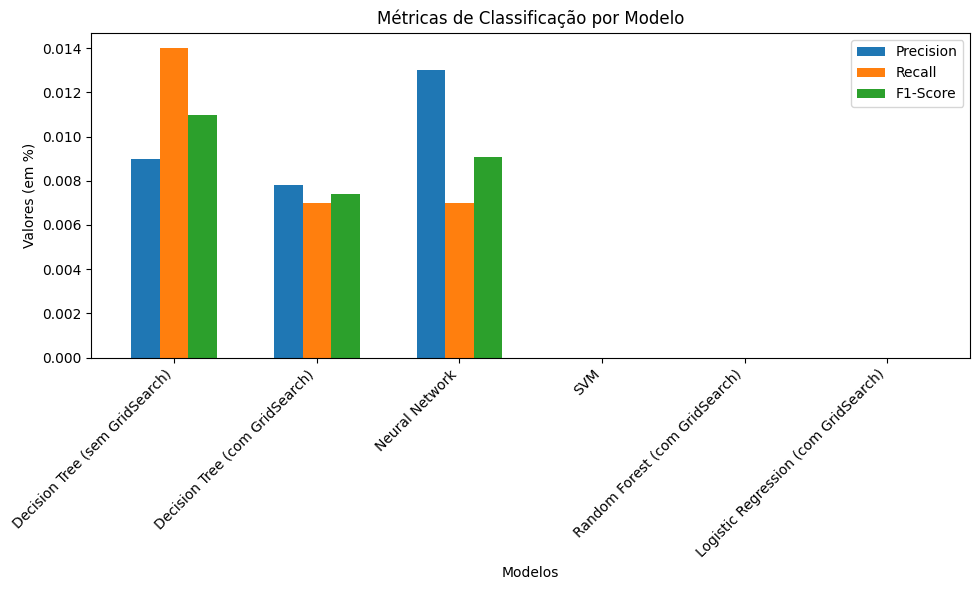

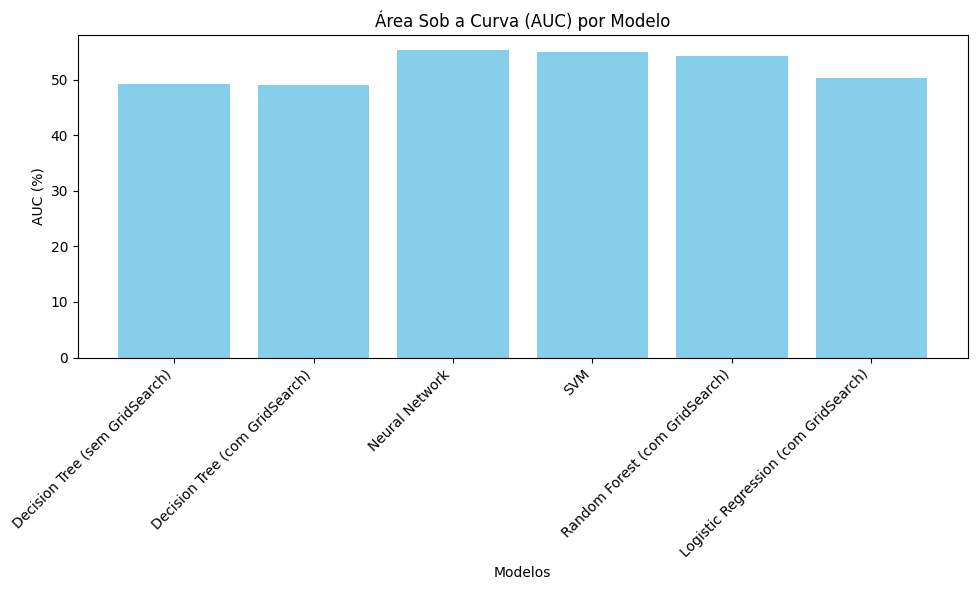

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Dados para os gráficos
models = [
    "Decision Tree (sem GridSearch)",
    "Decision Tree (com GridSearch)",
    "Neural Network",
    "SVM",
    "Random Forest (com GridSearch)",
    "Logistic Regression (com GridSearch)"
]

precision = [0.009, 0.0078, 0.013, 0.0, 0.0, 0.0]
recall = [0.014, 0.007, 0.007, 0.0, 0.0, 0.0]
f1_score = [0.011, 0.0074, 0.0091, 0.0, 0.0, 0.0]
auc = [49.2, 49.09, 55.32, 54.97, 54.28, 50.26]

# Gráfico de Precision, Recall, e F1-Score
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel("Modelos")
ax.set_ylabel("Valores (em %)")
ax.set_title("Métricas de Classificação por Modelo")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

# Gráfico de AUC
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(models, auc, color='skyblue', label='AUC')

ax.set_xlabel("Modelos")
ax.set_ylabel("AUC (%)")
ax.set_title("Área Sob a Curva (AUC) por Modelo")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")

plt.tight_layout()
plt.show()


Com base nos resultados apresentados na tabela, podemos tirar as seguintes conclusões em relação ao desempenho dos modelos:

### Melhor Modelo Baseado no AUC

O modelo **Rede Neural** apresentou o maior AUC, com **55.32%**. Isso indica que, entre os modelos testados, este teve a melhor capacidade de distinguir as classes positivas e negativas. Apesar do AUC ser o mais alto, a **Precision (1.30%)**, **Recall (0.70%)** e **F1-Score (0.91%)** são muito baixos, o que indica que o modelo tem dificuldades em classificar corretamente os exemplos positivos.

### Desempenho Geral dos Modelos

**Decision Tree sem GridSearch:**

Teve um AUC de **49.20%**, próximo ao valor aleatório (50%). No entanto, a **Precision (0.90%)**, **Recall (1.40%)** e **F1-Score (1.10%)** foram ligeiramente melhores que os outros modelos que têm valores nulos.

**Decision Tree com GridSearch:**

O AUC caiu ligeiramente para **49.09%**, mas apresentou **Precision (0.78%)**, **Recall (0.70%)** e **F1-Score (0.74%)** consistentes.

**SVM, Random Forest e Logistic Regression:**

Estes três modelos tiveram **Precision, Recall e F1-Score iguais a 0%**, o que sugere que não foram capazes de classificar corretamente exemplos positivos no conjunto de testes. O AUC de **54.97% (SVM)** e **54.28% (Random Forest)** mostra alguma capacidade de distinguir classes, mas os valores baixos nas métricas de classificação indicam que esses modelos falharam em encontrar padrões relevantes.

**Random Forest com GridSearch:**

Apesar de ser uma técnica de ensembling robusta, a incapacidade de classificar exemplos positivos reflete problemas na generalização.

**Logistic Regression com GridSearch:**

Com um AUC de **50.26%**, o modelo apresentou desempenho equivalente ao aleatório (quase). Todas as outras métricas também são 0%, o que indica que falhou em obter os padrões necessários para separar as classes.

### Conclusões Gerais

**Modelo com Melhor Desempenho:** Embora tenha o melhor AUC, a **Rede Neural** não apresenta desempenho satisfatório nas outras métricas. Isso pode ser atribuído ao desequilíbrio dos dados. Contudo, é terá que ser considerado o melhor modelo por ter o AUC mais alto e ter tido um desempenho melhor nas outras métricas.

**Problemas Identificados:** A incapacidade de muitos modelos (SVM, Random Forest, Logistic Regression) em classificar exemplos positivos pode estar relacionada com o desbalanceamento extremo do dataset, apesar de se usar técnicas como **SMOTE com Tomek Links**.

**Próximos Passos:** Avaliar estratégias de pré-processamento mais eficazes (como *oversampling* mais agressivo ou novos métodos de balanceamento), ajustar parâmetros para os modelos e explorar novas técnicas de **ensembling**.